Settings: Interpolating Deflections
===================================

This example demonstrates how to use deflection-angles interpolation during a model-fit, which computes the deflection
angles of a `MassProfile` using a coarse lower resolution `interpolation grid` and interpolates these values to the
image`s native sub-grid resolution and then traces them to the source-plane for the source model.

**Benefit:** For a mass profile where the deflection angle calculation is computationally expensive this reduces the
number of deflection angle evaluations from 100000`s to 1000`s, giving a potential speed up in run time of x100 or more!

**Downside:** The interpolated deflection angles will be inaccurate to some level of precision, depending on the
resolution of the interpolation grid. This could lead to inaccurate and biased mass models.

The interpolation grid is defined in terms of a pixel scale and it is automatically matched to the mask used in that
search. A higher resolution grid (i.e. lower pixel scale) will give more precise deflection angles, at the expense
of longer calculation times. In this example we will use an interpolation pixel scale of 0.05", which balances run-time
and precision.

In this example, we fit the lens's mass using an `EllSersic` bulge and `EllNFW` dark matter mass model.
These are some of the slowest mass profiles in **PyAutoLens**, thus the use of interpolation should provide a nice
speed up.

Only slow `MassProfiles` use the interpolatioon grid; fast mass-profiles (by default) omit it. Whether a `MassProfile`
uses this grid is set via the following config file:

 `autolens_workspace/config/grids/interpolate.ini`

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Settings Specific Code__

To use deflection angle interpolation, we create a `SettingsImaging` object and specify that the 
`grid_class=al.Grid2DInterpolate` and `pixel_scales_interp=0.05`. 

By using a `Grid2dInterpolate` the interpolation scheme described above is used, with the coarse grid used to compute 
deflection angles having a pixel-scale of 0.05". 

In [2]:
settings_imaging = al.SettingsImaging(
    grid_class=al.Grid2DInterpolate, pixel_scales_interp=0.05
)

__Dataset + Masking__ 

For this sub-grid to be used in the model-fit, we must pass the `settings_imaging` to the `Imaging` object,
which will be created using a `Grid2D` with a `sub-size value` of 4 (instead of the default of 2).

In [3]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

imaging = imaging.apply_settings(
    settings=settings_imaging
)  # <----- The `SettingsImaging` above is used here!

__Masking__

The model-fit requires a `Mask2D` defining the regions of the image we fit the lens model to the data, which we define
and use to set up the `Imaging` object that the lens model fits.

In [4]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

__Model + Search + Analysis__ 

The code below performs the normal steps to set up a model-fit. We omit comments of this code as you should be 
familiar with it and it is not specific to this example!

In [5]:
bulge = af.Model(al.lmp.EllSersic)
dark = af.Model(al.mp.EllNFW)
bulge.centre = dark.centre

lens = af.Model(al.Galaxy, redshift=0.5, bulge=bulge, dark=dark)
source = af.Model(al.Galaxy, redshift=1.0, bulge=al.lp.EllSersic)

model = af.Collection(galaxies=af.Collection(lens=lens, source=source))

search = af.DynestyStatic(
    path_prefix=path.join("imaging", "settings"),
    name="interpolating_deflections",
    n_live_points=100,
    walks=10,
)

analysis = al.AnalysisImaging(dataset=imaging)

__Model-Fit__

We now begin the model-fit by passing the model and analysis object to the search, which performs a non-linear search 
to find which models fit the data with the highest likelihood.

Because the `AnalysisImaging` was passed a `Imaging` with a `al.Grid2DInterpolate`, deflection angle interpolation 
is used to speed-up the evalution of the mass models deflection angles.

In [6]:
result = search.fit(model=model, analysis=analysis)

INFO:root:No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  6.11it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.109]
INFO:root:2500 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:5000 Iterations: Performing update (Visualization, outputting samples, etc.).
INFO:root:7500 Iterations: Performing update (Visualization, outputting samples, etc.).


__Result__

We can confirm that the `Result`'s grid used a `Grid2DInterpolate`.

<class 'autoarray.structures.grids.two_d.grid_2d_interpolate.Grid2DInterpolate'>


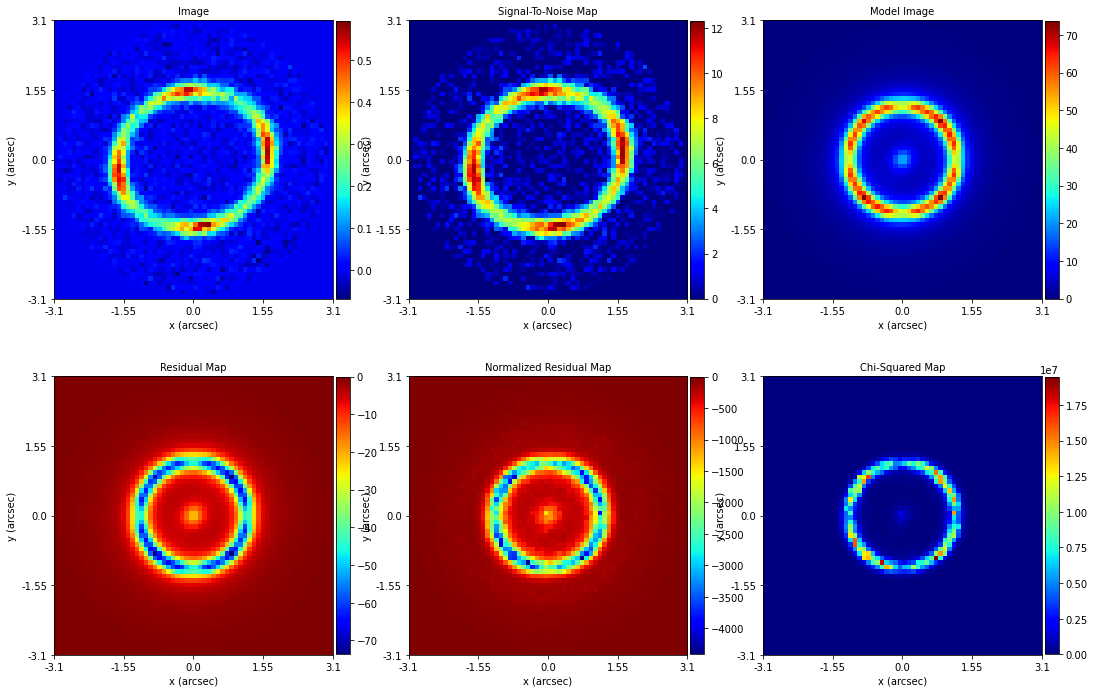

In [7]:
print(type(result.grid))

fit_imaging_plotter = aplt.FitImagingPlotter(fit=result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

Finish.